# Dimension Reduction V: Independent Component Analysis (ICA)
### Implemented in Python

<i>Patrick White</i></br>
<i>Jan 07, 2025</i>

<img src="img/dr5.png" style="height: 450px; width:auto;">

# Outline

- Theoretical Foundation
- Solving ICA
- Implementation
- Advantages and Limitations
- Scikit-Learn Implementation Details
    - Parameters
    - Attributes
    - Methods
- What’s Next?

# Theoretical Foundation

Independent component analysis (ICA) is a source separation technique that can be used to remove noise, extract features, and separate independent sources from a mixed signal. Examples of mixed signals include audio recordings with multiple microphones, and EEG data of brain activity taken via multiple electrodes simultaneously. By the method it is computed, it assumes the true sources to be non-Gaussian and statistically independent.

ICA describes how the observed data $\mathbf{x}$ are generated by a process of mixing the components $\mathbf{s}$. The independent components are latent variables which we cannot observe directly, but we observe the vector $\mathbf{x}$, and must estimate both the mixing matrix $\mathbf{A}$ and the true sources $\mathbf{s}$ from it.

$\mathbf{x} = \mathbf{As} = \sum_{i=1}^n \mathbf{a}_i s_i$

----
<i>"A key assumption is that the observed data $\mathbf{x}$ is a linear mixture of the underlying sources, $\mathbf{x} = \mathbf{As}$, where $\mathbf{A}$ is some invertible, square matrix that mixes the components of the sources."</i>
- A Tutorial on Independent Component Analysis (2014)
----

# Solving ICA

Rather than trying to solve for $\mathbf{s}$ and $\mathbf{A}$ at the same time, we focus first on finding $\mathbf{A}$. SVD provides a method to divide $\mathbf{A}$ into pieces: a rotation $\mathbf{V}$, a stretch along the axes $\mathbf{\Sigma}$, and a second rotation $\mathbf{U}$. We estimate $\mathbf{A}$ and its inverse $\mathbf{W}$ by recovering each piece of the decomposition individually.

$\mathbf{W} = \mathbf{A}^{-1} = \mathbf{V} \mathbf{\Sigma}^{-1} \mathbf{U}^T$

We can proceed to solve for the unmixing matrix $\mathbf{W}$ by examining the covariance of the data $\mathbf{x}$ to calculate $\mathbf{U}$ and $\mathbf{\Sigma}$, and then return to the assumption of independence of $\mathbf{s}$ to solve for $\mathbf{V}$.

---- 
<i>"The success of ICA must be tempered with several computational issues and inherent amiguities in the solution. In the computation of the unmixing matrix $\mathbf{W} = \mathbf{V \Sigma}^{-1} \mathbf{U}^T$. The matrices $\mathbf{\Sigma}^{-1}$ and $\mathbf{U}$ are analytically calculated from the data. The matrix $\mathbf{V}$ has no analytical form and must be approximated numerically through an optimization procedure."</i>
- A Tutorial on Independent Component Analysis (2014)
---- 

Any symmetric matrix, including a covariance matrix, is orthogonally diagonalized by its eigenvectors. Consider a matrix $\mathbf{E}$, whose columns are the eigenvectors of the covariance of $\mathbf{x}$.

$\langle \mathbf{xx}^T \rangle = \mathbf{EDE}^T$

where $\mathbf{D}$ is a diagonal matrix of eigenvalues.

This identifies a partial solution for $\mathbf{A}$: $\mathbf{U}$ is a matrix of eigenvectors of the covariance matrix and $\mathbf{\Sigma}$ is a diagonal matrix with the square root of the associated eigenvalue in $\mathbf{D}$.

$\mathbf{W} = \mathbf{VD}^{-1/2} \mathbf{E}^T$

This has performed whitening, a removal of all linear dependencies and normalization of the variance along all dimensions. This is also known as sphering, as whitening maps the data into a sperically symmetrical distribution.

The problem of ICA searches for the rotation matrix $\mathbf{V}$ such that $\mathbf{s}$ is statistically independent. Multi-information, a generalization of mutual information, is one option to measure the statistical independence between multiple variables.

$I(y) = \int P(\mathbf{y}) log_2 \frac{P(\mathbf{y})}{\prod_i P(y_i)} d \mathbf{y}$

So the goal can be stated as finding a rotation matrix $\mathbf{V}$ such that $I(\mathbf{\hat{s}}) = 0$. The optimization involves finding a rotation matrix that minimizes the sum of the marginal entropies of $\mathbf{\hat{s}}$, and there are many strategies for approximating this.

There are multiple distinct but equivalent interpretations of this optimization. As mentioned above, we have maximized non-Gaussianity. We have also maximized the log-likelihood of the observed data under the assumption that the data arose from a statistically independent distribution.

In summary, we have identified an optimization that permits us to estimate $\mathbf{V}$ and in turn, reconstruct the original statistically independent source signals $\mathbf{\hat{s}} = \mathbf{Wx}$. The columns of $\mathbf{W}^{-1}$ are the independent components of the data.

# Implementation

Below, I will use Scikit-Learn's FastICA implementation to perform blind source separation on simulated data. First, I'll import libraries used to generate and visualize the simulated data.

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

Then, generate an x-axis and 3 functions: one a sine wave, one a square wave, and one a sawtooth.

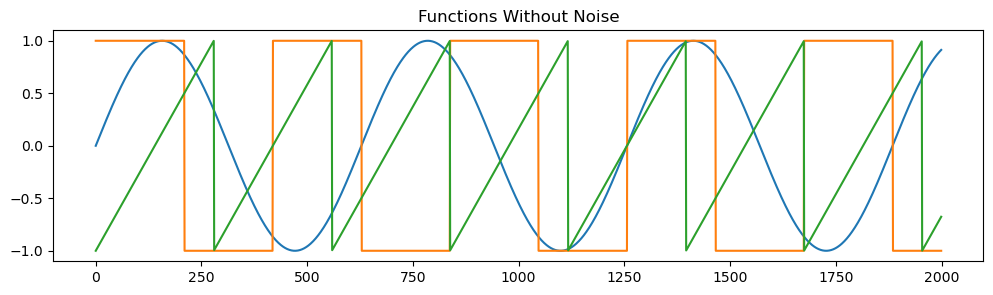

In [2]:
xx = np.linspace(0,10,2000) # x-axis

s1 = np.sin(2 * xx)  # sine wave
s2 = signal.square(3 * xx)  # square wave
s3 = signal.sawtooth(4.5 * xx)  # sawtooth wave

S = np.c_[s1, s2, s3] # concatenate vectors into matrix

# plot overlaid functions
plt.figure(figsize=(12,3))
plt.title('Functions Without Noise')
plt.plot(S);

To make the data more realistic, we'll add noise. These noise-augmented values will be considered our true sources.

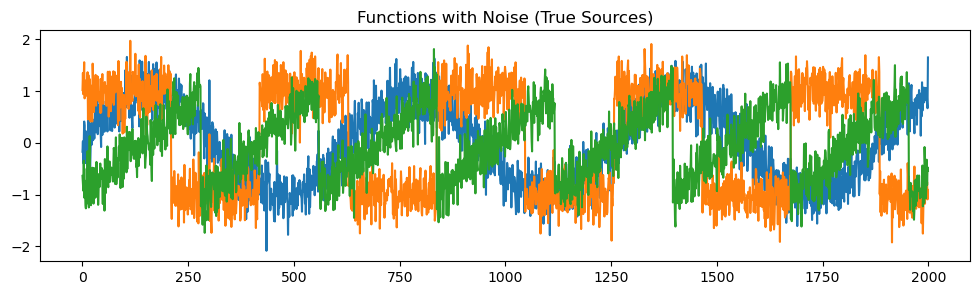

In [3]:
S += 0.3 * np.random.normal(size=S.shape) # add noise

# plot overlaid signals
plt.figure(figsize=(12,3))
plt.title('Functions with Noise (True Sources)')
plt.plot(S);

Next, we'll mix the signals according to a mixing matrix, the values of which I will choose at random (but use a seed for reproducibility).

In [4]:
np.random.seed(123)
A = np.random.randn(3,3)

Then, mix the sources with the mixing matrix through matrix multiplication, and plot the results. This is the mixed signal we will ask ICA to decompose.

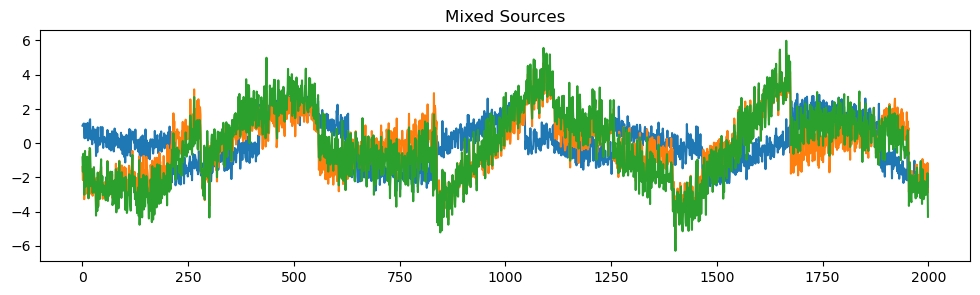

In [5]:
X = S@A.T # combine the sources and mixing matrix

plt.figure(figsize=(12,3))
plt.title('Mixed Sources')
plt.plot(X);

Next, I'll run the ICA operation and plot the reconstructed signals.

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


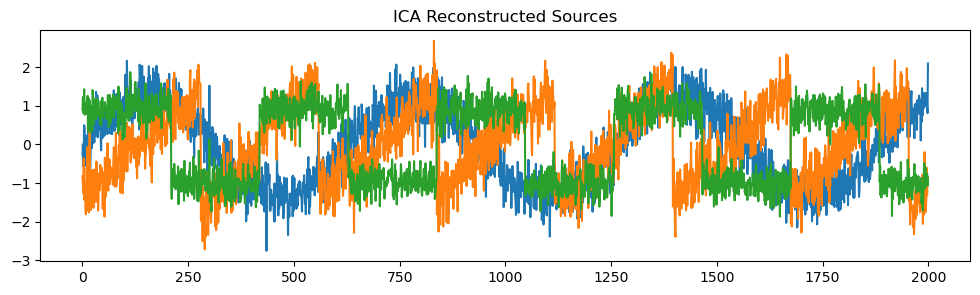

In [6]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=3, whiten='unit-variance')
S_ = ica.fit_transform(X)  # reconstruct signals

plt.figure(figsize=(12,3))
plt.title('ICA Reconstructed Sources')
plt.plot(S_);

Very impressive! Now, for comparison, let's see how well PCA is able to reconstruct the sources.

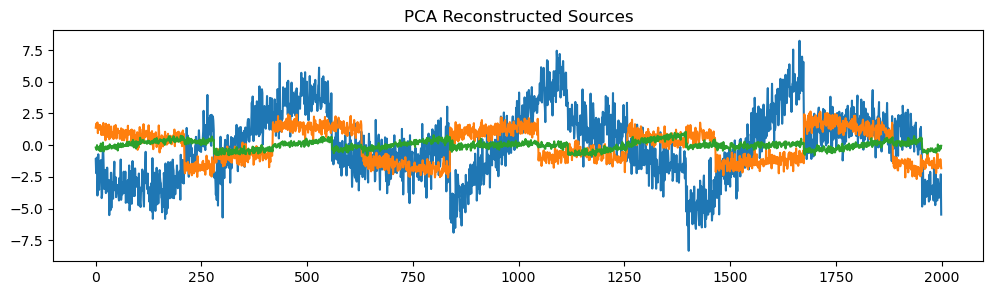

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

plt.figure(figsize=(12,3))
plt.title('PCA Reconstructed Sources')
plt.plot(H);

Not very well! PCA constrains the components to be orthogonal, and seeks to aborb as much variance into the first principal component as possible (which is apparent in the visual). Clearly ICA seems to have the advantage when it comes to blind source separation.

# Advantages and Limitations

ICA excels at the ‘cocktail party’ problem (i.e., blind source separation) of separating individual voices from a mixed audio recording, by exploiting statistical independence. It is not limited to linear transformations, nor are the components constrained to be orthogonal. The assumption of non-Gaussian components can be favorable (and flexible), but disadvantageous if the data is very normally distributed. It requires preprocessing such as centering and whitening, and can face scalability issues with very large datasets due to computational complexity and the nature of algorithms used.

# Scikit-Learn Implementation Details

<code>sklearn.decomposition.FastICA(n_components=None, *, algorithm='parallel', whiten='unit-variance', fun='logcosh', fun_args=None, max_iter=200, tol=0.0001, w_init=None, whiten_solver='svd', random_state=None)</code>

## Parameters

- <code>n_components</code> (default=all): number of components to use.

- <code>whiten</code> (default='unit-variance'): the whitening strategy to use.

    - if 'arbitrary-variance', whitening without variance-constraint is performed.

    - if 'unit-variance', the whitening matrix is rescaled to ensure that each recovered source has unit variance.

    - if False, the data is considered to be whitened already, so no whitening is preferred.

- <code>max_iter</code> (default=200): max number of iterations during training.

- <code>random_state</code> (default=None): random seed for reproducible results


## Attributes

- <code>components_</code>: the linear operator to apply to get the independent sources.

- <code>n_features_in_</code>: the number of features seen during fit.


## Methods

- <code>fit</code>: fit an instance of the model to the data

- <code>fit_transform</code>: fit an instance of the model to the data, and apply the dimensionality reduction to the data.

- <code>inverse_transform</code>: transform the data back to its original space.

# What’s Next?

We’ve concluded the dimension reduction techniques that rely heavily on linear algebra, and techniques like eigendecomposition. The next article covers t-Stochastic Neighbor Embedding (t-SNE), a probabilistically driven method for clustering, and the following article will cover a similar technique called uniform manifold approximation projection (UMAP).

# References

- Hyvärinen, A., & Oja, E. (2000). Independent Component Analysis: Algorithms and Applications. Neural Networks. https://doi.org/13(4-5):411-430

- Shlens, J. (2014). A Tutorial on Independent Component Analysis. ArXiv. https://doi.org/1404.2986v1

- Scikit-Learn (n.d.). Decomposing signals in components. Scikit-Learn User Guide. https://scikit-learn.org/stable/modules/decomposition.html#ica

- Maklin, C. (n.d.). Independent Component Analysis (ICA) In Python. Towards Data Science. https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e

- Amir (n.d.). Independent Component Analysis (ICA) with python code. https://medium.com/@ab.jannatpour/independent-component-analysis-ica-with-python-code-e7d1dd290241

- https://github.com/akcarsten/Independent_Component_Analysis/blob/master/Independent_component_analysis.ipynb